# Cosine Similarity on FCC comments

In [28]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction, pipeline, metrics, preprocessing 
import os
import json
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load single file (10k comments)

In [3]:
data_dir = 'ECFS_17-108_1'

In [4]:
filenames = os.listdir(data_dir)

In [5]:
comment_file = filenames[0]
with open(data_dir + '/'+ comment_file, 'rr') as comment_fobj:
    comments = json.load(comment_fobj)

In [6]:
len(comments)

10000

### Examine data structure of each comment record

In [7]:
comment = comments[1]

Each comment is a dictionary with the below keys

In [8]:
type(comment)

dict

In [9]:
print comment.keys()

[u'date_last_modified', u'date_disseminated', u'report_number', u'total_page_count', u'id_edocs', u'entity', u'reg_flex_analysis', u'internationaladdressentity', u'text_data', u'id_submission', u'file_number', u'text_data_docs', u'documents', u'fcc_record', u'date_submission', u'is_staff_upload', u'filingstatus', u'date_received', u'date_comment_period', u'addressentity', u'filers', u'bureau_id', u'small_business_impact', u'submissiontype', u'is_action', u'lawfirms', u'authors', u'viewingstatus', u'bureaus', u'delegated_authority_number', u'_index', u'express_comment', u'trackChanges', u'date_reply_comment', u'proceedings']


The `text_data` field contains the text of the comment if it was entered as text instead of an attached document, and the `id_submission` key is the unique key for each record. 

Make a numpy matrix of records that have text data as a field and some text entered in the field

In [10]:
comment_text = pd.Series({i['id_submission']:i['text_data'] for i in comments
                             if ('text_data' in i) and len(i['text_data']) > 0})

In [11]:
text_matrix = comment_text.values
text_matrix.shape

(9945,)

Check out the length of the text entered in the field. The smallest entries seems to actually be complete text so I'll leave them in for analysis

In [12]:
comment_text.map(lambda x: len(x)).nsmallest(10)

10430209710869      3
104303015524263     3
10428054006393      9
10501276272447     19
104280741803285    20
10428652221977     20
1043025441907      20
10428852220306     21
10429359506455     21
10428633709110     22
dtype: int64

In [13]:
comment_text.loc[comment_text.map(lambda x: len(x)).nsmallest(10).index]

10430209710869                        NO!
104303015524263                       NO!
10428054006393                  Vote "NO"
10501276272447        keep net neutrality
104280741803285      Save net neutrality!
10428652221977       Please don't do this
1043025441907        Keep the net neutral
10428852220306      A vote against 17-108
10429359506455      I disagree with these
10428633709110     Retain net neutrality!
dtype: object

Build a pipeline to compute cosine similarity, treating the comments as documents. 

In [14]:
doc_vec_pipe = pipeline.make_pipeline(
    feature_extraction.text.CountVectorizer(),
    feature_extraction.text.TfidfTransformer(),
    preprocessing.FunctionTransformer(metrics.pairwise.cosine_similarity, validate=False)
)

In [15]:
comment_sim = doc_vec_pipe.fit_transform(text_matrix)

In [16]:
sim_df = pd.DataFrame(comment_sim, index=comment_text.index, columns=comment_text.index)

Since the matrix of similarities is pairwise, I halve it and remove the diagonal entries in order to summarize the frequency of different degrees of computed similarity. The result is that quite a few documents are 1.0 on cosine similarity indicating they have precisely the same tf-idf matrix. 

In [17]:
half_df_len = int(np.ceil(len(sim_df)/2.))
half_df_long = sim_df.iloc[:half_df_len].stack().reset_index()
half_df_long.columns = ['comm_1', 'comm_2', 'similarity']
half_df_long = half_df_long.loc[(half_df_long.comm_1 != half_df_long.comm_2)].copy()
print 'Deciles of computed comment similarity'
print half_df_long.similarity.quantile(np.arange(0.1,1,0.1))

Deciles of computed comment similarity
0.1    0.083993
0.2    0.130317
0.3    0.175486
0.4    0.231025
0.5    0.282587
0.6    0.285804
0.7    0.399911
0.8    1.000000
0.9    1.000000
Name: similarity, dtype: float64


In fact - going back to the matrix of original comment text, 6364 of the original ~9950 are duplicated comments, and there are only 3581 unique document

In [18]:
print 'duplicated comments:', comment_text.str.lower().duplicated().sum()
print 'total unique documents:', comment_text.str.lower().nunique()

duplicated comments: 6364
total unique documents: 3581


In [19]:
orig_is_duplicated = comment_text.str.lower().duplicated(keep=False)
unique_docs = comment_text.str.lower().drop_duplicates(keep='first')

In [20]:
orig_is_duplicated.head(10)

10427001400172      True
1042700369437       True
104270060314698     True
104270076028229    False
10427008522807     False
10427008740029     False
104270106518349     True
10427013726370      True
10427014023199      True
10427015307336      True
dtype: bool

In [21]:
unique_docs = comment_text.loc[unique_docs.index]

### Duplicated comments

Looking at documents that are extremely similar but not the same reveals largely identical comments with one/two small differences in additional phrases or sentences. 

In [22]:
# using the long DF with diagonal entries removed, find some comments that are similar between 0.9 & 1
sim_only = half_df_long.set_index(['comm_1','comm_2'])
sim_comment_idxes = sim_only.loc[(sim_only.similarity >= 0.90) & (sim_only.similarity < 1)].index.values

In [23]:
comment_text.loc[sim_comment_idxes[2][0]]

u'Obama\u2019s Title II order has diminished broadband investment, stifled innovation, and left American consumers potentially on the hook for a new broadband tax.\r\n\r\nThese regulations ended a decades-long bipartisan consensus that the Internet should be regulated through a light touch framework that worked better than anyone could have imagined and made the Internet what it is.\r\n\r\nFor these reasons I urge you to fully repeal the Obama/Wheeler Internet regulations.'

In [24]:
comment_text.loc[sim_comment_idxes[2][1]]

u"Obama\u2019s Title II order has diminished broadband investment, stifled innovation, and left American consumers potentially on the hook for a new broadband tax.\r\n\r\nThese regulations ended a decades-long bipartisan consensus that the Internet should be regulated through a light touch framework that worked better than anyone could have imagined and made the Internet what it is. WE DON'T NEED ANOTHER OBAMA ERA TAX.\r\n\r\nFor these reasons I urge you to fully repeal the Obama/Wheeler Internet regulations."

Plotting the similarity for the 5 most duplicated comments there's a clear separation between other comments and those that are duplicates or near-duplicates of the original

In [25]:
five_most_common = comment_text.value_counts().head(5).index
mc_doc_ids = unique_docs.loc[unique_docs.isin(five_most_common)].index

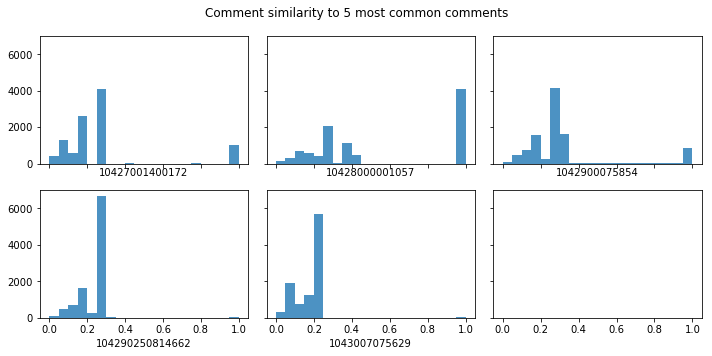

In [64]:
fig, axes = plt.subplots(2,3, sharex=True, sharey=True)
fig.set_size_inches(10,5)
fig.suptitle('Comment similarity to 5 most common comments')
for n, did in enumerate(mc_doc_ids):
    i = n % 3
    j = n / 3
    sns.distplot(sim_df.loc[:,did], kde=False, ax=axes[j,i], bins=20, hist_kws={'alpha':0.8})
fig.tight_layout()
fig.subplots_adjust(top=0.9)

The [Pew Research Center](http://www.pewinternet.org/2017/11/29/public-comments-to-the-federal-communications-commission-about-net-neutrality-contain-many-inaccuracies-and-duplicates/) did a study that treated two comments with cosine similarity of 0.95 or above as being effectively duplicated. Using their threshold, I tried out two methods of de-duplicating the data. Both methods revolve around functions that return the index of "nearby" duplicate comments that meet the Pew threshold of 0.95. 

The first function looks at the pariwise similarities for a given comment (excluding the similarity of the comment to itself) and checks for similarities meeting the threshold. If none exist, it returns the ID of the comment itself. If there are comments meeting this threshold, the function returns the index of the most similar comment.

In [172]:
def near_duplicate(comment_id):
    non_diag_col = sim_df.loc[sim_df.index != comment_id, comment_id]
    near_dup = (non_diag_col >= 0.95)
    if near_dup.any():
        return non_diag_col.loc[near_dup].idxmax()
    else:
        return comment_id

The second function functions exactly the same as the first except in the case that comments exist meeting the duplicate threshold. If this is the case, the function returns the lowest index value of the set of similar comments. My hope here is that in a group of 10 very similar comments, each will reliably be anchored to a given index (the minimum) even if the precise similarity values are marginally different between comments.

In [174]:
def near_duplicate_alt(comment_id):
    non_diag_col = sim_df.loc[sim_df.index != comment_id, comment_id]
    near_dup = (non_diag_col >= 0.95)
    if near_dup.any():
        return str(np.min(non_diag_col.loc[near_dup].index.values.astype('int')))
    else:
        return comment_id

Implement both functions against the original comment text

In [173]:
near_dup_match = (pd.Series(comment_text.index.values,
                           index = comment_text.index.values)
                        .apply(lambda x: near_duplicate(x))
                 )

In [175]:
near_dup_match_alt = (pd.Series(comment_text.index.values,
                           index = comment_text.index.values)
                        .apply(lambda x: near_duplicate_alt(x))
                 )

The counts of matched duplicates using each method make me think that the alternate (second) function is better at grouping together similar comments under a mutual index representing them all, and therefore making them easier to de-duplicate. I'll spare some ugly output, but examining the top comments by matches against some of the middle-range ones (10-50 matches) the second one does a better job of picking up mostly similar duplicates

In [224]:
near_dup_match.value_counts().head(20)

10428000001057     4061
10427001400172     1000
1042900075854       809
104280311227630     563
1043007075629        38
10429145232009       32
1042815810562        27
1042801422130        24
104290250814662      20
10428003917468       20
104283041605798      19
104291982927182      14
10429013729540       13
10429298627238       13
1042909599704        12
10429070456063       12
1042912459376        12
104282626906075      12
10429021436718       11
10429079375703       11
dtype: int64

In [225]:
near_dup_match_alt.value_counts().head(20)

1042800175879    4062
1042800320378    1581
1042700369437    1003
1042900075854     854
1043007075629      39
1042807284028      21
1042930845634      21
1042909716112      14
1042954234454      12
1042809128837      11
1042817046196      10
1042876816445       9
1042867657322       8
1042886644141       8
1042839617911       7
1042844960180       7
1042897425930       7
1042815880412       6
1042974510094       6
1042809663113       6
dtype: int64

**De-Duplicating**  
Using the second method described above

In [204]:
# make a DF with comment ID as index, with near match column and a column for how many duplicates
# comment matches
near_match_df = pd.DataFrame(near_dup_match_alt, columns=['near_match'])
near_match_df['match_count'] = near_match_df.groupby('near_match').near_match.transform('count')

In [207]:
# replace the nearby match for comments with less than 5 matches with their own index
five_plus_match = (near_match_df['match_count'] >= 5)
near_match_df.loc[~five_plus_match,'near_match'] = pd.Series(near_match_df.index.values,
                                                             index=near_match_df.index.values)

In [209]:
dedup_comments = comment_text.loc[near_match_df.near_match.unique()].copy()

### Rebuild similarity
Now there's a largely de-duplicated set, I rebuilt cosine similarity pipeline, including coutn vectorization and tf-idf representation of each comment. 

In [210]:
unique_comment_sim = doc_vec_pipe.fit_transform(dedup_comments.values)

In [211]:
unique_comment_sim.shape

(2273, 2273)

In [213]:
u_sim_df = pd.DataFrame(unique_comment_sim, index=dedup_comments.index, columns=dedup_comments.index)

In [214]:
u_sim_df.iloc[:5,:5]

,1042700369437,104270076028229,10427008522807,10427008740029,10427015917315
1042700369437,1.000000,0.074712,0.109886,0.042842,0.043663
104270076028229,0.074712,1.000000,0.142176,0.049522,0.081031
10427008522807,0.109886,0.142176,1.000000,0.092348,0.093899
10427008740029,0.042842,0.049522,0.092348,1.000000,0.030745
10427015917315,0.043663,0.081031,0.093899,0.030745,1.000000


In [222]:
u_sim_df.loc[:,'1042800175879'].nlargest(5)

1042800175879     1.000000
10429718408466    0.331069
1042839359951     0.306062
1043062580419     0.290599
1042970440204     0.282896
Name: 1042800175879, dtype: float64

Re-examining the frequency of different levels of similarity it's clear that this represents a more expected range for more unique documents

In [221]:
half_df_len = int(np.ceil(len(sim_df)/2.))
half_df_long = u_sim_df.iloc[:half_df_len].stack().reset_index()
half_df_long.columns = ['comm_1', 'comm_2', 'similarity']
half_df_long = half_df_long.loc[(half_df_long.comm_1 != half_df_long.comm_2)].copy()
print 'Deciles of computed comment similarity'
print half_df_long.similarity.quantile(np.arange(0.1,1,0.1))

Deciles of computed comment similarity
0.1    0.038097
0.2    0.058581
0.3    0.075635
0.4    0.091339
0.5    0.106962
0.6    0.123631
0.7    0.142432
0.8    0.165928
0.9    0.200886
Name: similarity, dtype: float64


From here, I think it would be interesting to do some sentiment analysis or topic modeling to compare more original comments to some of the highly repeated comments in order to classify them as being for/against net neutrality.